In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#my imports
import env
import os
import wrangle as w
import explore as e

In [2]:
#Get my data
df = w.acquire_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52441 non-null  int64  
 1   propertylandusetypeid         52441 non-null  float64
 2   typeconstructiontypeid        76 non-null     float64
 3   storytypeid                   47 non-null     float64
 4   airconditioningtypeid         13638 non-null  float64
 5   architecturalstyletypeid      70 non-null     float64
 6   buildingclasstypeid           0 non-null      float64
 7   heatingorsystemtypeid         33935 non-null  float64
 8   id                            52441 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52441 non-null  float64
 11  bedroomcnt                    52441 non-null  float64
 12  buildingqualitytypeid         33740 non-null  float64
 13  c

In [4]:
df = w.prepare_zillow(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50709 entries, 0 to 52440
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   parcel_id               50709 non-null  int64  
 1   propertylandusetypeid   50709 non-null  float64
 2   basement_sqft           50709 non-null  float64
 3   bath_count              50709 non-null  float64
 4   bed_count               50709 non-null  float64
 5   calc_bath_and_bed       50709 non-null  float64
 6   decktypeid              50709 non-null  float64
 7   calc_sqft               50709 non-null  float64
 8   finished_sqft12         50709 non-null  float64
 9   fips                    50709 non-null  float64
 10  fireplace_cnt           50709 non-null  float64
 11  full_bath_cnt           50709 non-null  float64
 12  has_hot_tub             50709 non-null  float64
 13  latitude                50709 non-null  float64
 14  longitude               50709 non-null

In [6]:
#Ensuring no nulls are present
df.isna().sum().sum()

0

In [7]:
df.head().T

,0,1,2,3,4
parcel_id,1.429752e+07,1.705289e+07,1.418624e+07,1.217790e+07,1.209508e+07
propertylandusetypeid,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
basement_sqft,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bath_count,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
bed_count,4.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
calc_bath_and_bed,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
decktypeid,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
calc_sqft,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
finished_sqft12,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
fips,6.059000e+03,6.111000e+03,6.059000e+03,6.037000e+03,6.037000e+03


In [8]:
df = e.create_features(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50654 entries, 0 to 52440
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   parcel_id                  50654 non-null  int64  
 1   propertylandusetypeid      50654 non-null  float64
 2   basement_sqft              50654 non-null  float64
 3   bath_count                 50654 non-null  float64
 4   bed_count                  50654 non-null  float64
 5   calc_bath_and_bed          50654 non-null  float64
 6   decktypeid                 50654 non-null  float64
 7   calc_sqft                  50654 non-null  float64
 8   finished_sqft12            50654 non-null  float64
 9   fips                       50654 non-null  float64
 10  fireplace_cnt              50654 non-null  float64
 11  full_bath_cnt              50654 non-null  float64
 12  has_hot_tub                50654 non-null  float64
 13  latitude                   50654 non-null  flo

In [10]:
df = e.get_counties(df)

In [11]:
df.head().T

,0,1,2,3,4
parcel_id,1.429752e+07,1.705289e+07,1.418624e+07,1.217790e+07,1.209508e+07
propertylandusetypeid,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02,2.610000e+02
basement_sqft,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bath_count,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
bed_count,4.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
calc_bath_and_bed,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
decktypeid,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
calc_sqft,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
finished_sqft12,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
fips,6.059000e+03,6.111000e+03,6.059000e+03,6.037000e+03,6.037000e+03


In [12]:
train, validate, test = w.train_validate_test_split(df)

In [13]:
train.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura
38935,14392368,261.0,0.0,2.5,4.0,2.5,0.0,2832.0,2832.0,6059.0,...,0.6,130.530014,0.4,35.481693,0.3,0.625000,0,0,1,0
31408,14368210,261.0,0.0,2.5,4.0,2.5,0.0,2255.0,2255.0,6059.0,...,0.5,75.004435,0.3,19.219286,0.2,0.625000,0,0,1,0
30966,11300975,261.0,0.0,3.0,3.0,3.0,0.0,1563.0,1563.0,6037.0,...,0.4,58.162508,0.2,3.176240,0.1,1.000000,0,1,0,0
5412,13926000,261.0,0.0,2.0,3.0,2.0,0.0,1447.0,1447.0,6059.0,...,0.3,32.089150,0.1,4.071429,0.1,0.666667,0,0,1,0
45802,17229160,261.0,0.0,2.5,3.0,2.5,0.0,1415.0,1415.0,6111.0,...,0.3,128.823322,0.4,22.875767,0.3,0.833333,0,0,0,1


In [14]:
#Make bins for log error
train['logerror_bins'] = pd.cut(train.log_error, [-5, -.2, -.05, .05, .2, 4])

In [15]:
train.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura,logerror_bins
38935,14392368,261.0,0.0,2.5,4.0,2.5,0.0,2832.0,2832.0,6059.0,...,130.530014,0.4,35.481693,0.3,0.625000,0,0,1,0,"(-0.05, 0.05]"
31408,14368210,261.0,0.0,2.5,4.0,2.5,0.0,2255.0,2255.0,6059.0,...,75.004435,0.3,19.219286,0.2,0.625000,0,0,1,0,"(0.05, 0.2]"
30966,11300975,261.0,0.0,3.0,3.0,3.0,0.0,1563.0,1563.0,6037.0,...,58.162508,0.2,3.176240,0.1,1.000000,0,1,0,0,"(0.05, 0.2]"
5412,13926000,261.0,0.0,2.0,3.0,2.0,0.0,1447.0,1447.0,6059.0,...,32.089150,0.1,4.071429,0.1,0.666667,0,0,1,0,"(0.05, 0.2]"
45802,17229160,261.0,0.0,2.5,3.0,2.5,0.0,1415.0,1415.0,6111.0,...,128.823322,0.4,22.875767,0.3,0.833333,0,0,0,1,"(-0.2, -0.05]"


In [ ]:
train.logerror_bins.value_counts()

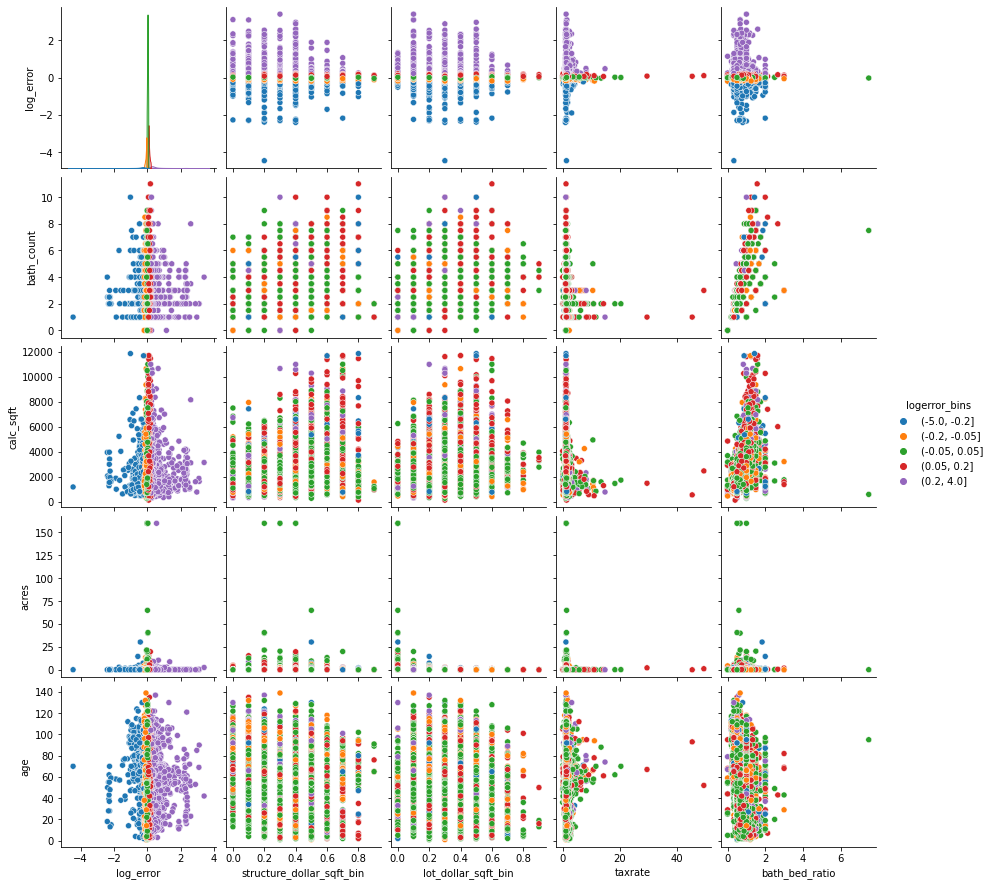

In [20]:
#Pairplot for log error bins
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['log_error', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['log_error', 'bath_count', 'calc_sqft', 'acres', 'age'])

In [ ]:
train.head().T

In [ ]:
#Ensuring no nulls are present
train.isna().sum().sum()

In [21]:
#Scaling variables
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['latitude', 'longitude', 'age'],return_scaler=False):
    '''This function takes in train, validate, test, and outputs scaled data based on
    the chosen method (quantile scaling) using the columns selected as the only columns
    that will be scaled. This function also returns the scaler object as an array if set 
    to true'''
    # make copies of our original data
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
     # select a scaler
    scaler = MinMaxScaler()
     # fit on train
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [22]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, 
                                                        columns_to_scale =
                                                       ['latitude','longitude','age'])

In [24]:
train_scaled.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura,logerror_bins
38935,14392368,261.0,0.0,2.5,4.0,2.5,0.0,2832.0,2832.0,6059.0,...,130.530014,0.4,35.481693,0.3,0.625000,0,0,1,0,"(-0.05, 0.05]"
31408,14368210,261.0,0.0,2.5,4.0,2.5,0.0,2255.0,2255.0,6059.0,...,75.004435,0.3,19.219286,0.2,0.625000,0,0,1,0,"(0.05, 0.2]"
30966,11300975,261.0,0.0,3.0,3.0,3.0,0.0,1563.0,1563.0,6037.0,...,58.162508,0.2,3.176240,0.1,1.000000,0,1,0,0,"(0.05, 0.2]"
5412,13926000,261.0,0.0,2.0,3.0,2.0,0.0,1447.0,1447.0,6059.0,...,32.089150,0.1,4.071429,0.1,0.666667,0,0,1,0,"(0.05, 0.2]"
45802,17229160,261.0,0.0,2.5,3.0,2.5,0.0,1415.0,1415.0,6111.0,...,128.823322,0.4,22.875767,0.3,0.833333,0,0,0,1,"(-0.2, -0.05]"


In [57]:
#Building a set for a location cluster
location = train_scaled[['latitude','longitude','age']]

In [58]:
location.head()

,latitude,longitude,age
38935,0.157768,0.912036,0.115942
31408,0.193394,0.941401,0.282609
30966,0.917439,0.732277,0.195652
5412,0.298116,0.736733,0.420290
45802,0.638955,0.369057,0.210145


In [69]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(location)
kmeans.predict(location)

array([2, 2, 3, ..., 2, 1, 2], dtype=int32)

In [70]:
train_scaled['location_cluster'] = kmeans.predict(location)

In [71]:
kmeans.cluster_centers_

array([[0.4521325 , 0.66877159, 0.52173276],
       [0.60541346, 0.39188796, 0.32663494],
       [0.28562283, 0.849552  , 0.28285273],
       [0.84462777, 0.68859219, 0.21088672]])

In [72]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=location.columns)
centroids

,latitude,longitude,age
0,0.452132,0.668772,0.521733
1,0.605413,0.391888,0.326635
2,0.285623,0.849552,0.282853
3,0.844628,0.688592,0.210887


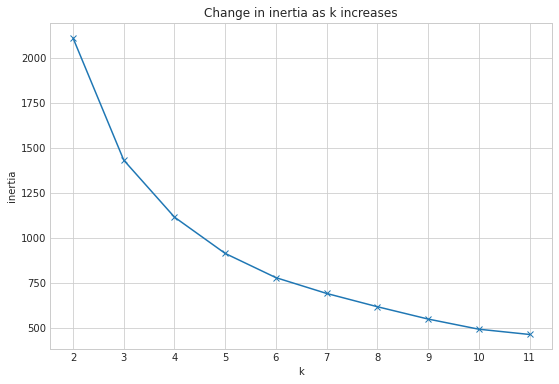

In [73]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(location).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [74]:
train_scaled.location_cluster.value_counts()

0    14805
2    10972
1     6810
3     2868
Name: location_cluster, dtype: int64

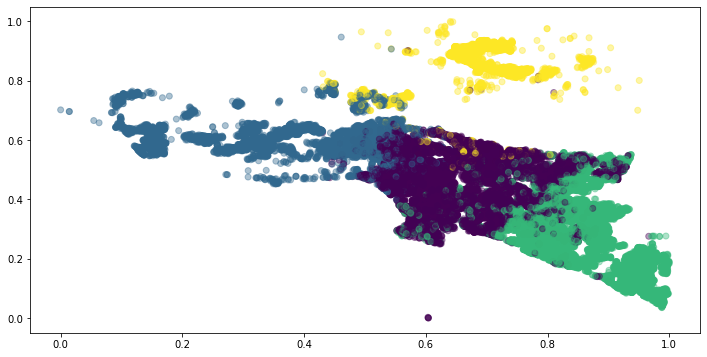

In [85]:
plt.figure(figsize=(12,6))
plt.scatter(y=train_scaled.latitude, x=train_scaled.longitude, c=train_scaled.location_cluster, alpha=.4)
#plt.scatter(y=train_scaled.age, x=train_scaled.longitude, c=train_scaled.location_cluster, alpha=.4)
#plt.scatter(y=train_scaled.age, x=train_scaled.latitude, c=train_scaled.location_cluster, alpha=.4)

Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

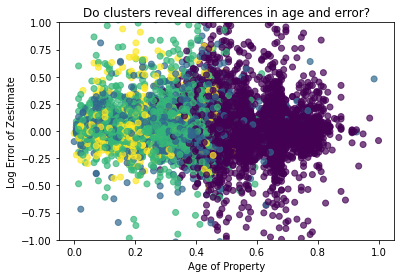

In [81]:
plt.scatter(y=train_scaled.log_error, x=train_scaled.age, c=train_scaled.location_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")

(-1.0, 1.0)

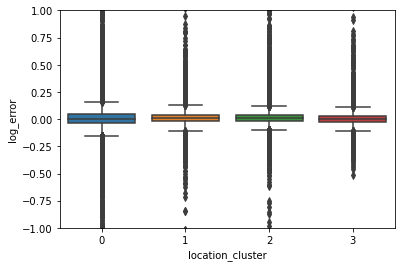

In [86]:
import seaborn as sns
sns.boxplot(y=train_scaled.log_error, x=train_scaled.location_cluster)
plt.ylim(-1, 1)
# sns.swarmplot(X_train.age_bin, y_train.logerror, hue=X_train.area_cluster)